Please upload your video file to the Colab environment. You can do this by clicking the folder icon on the left sidebar, then the 'Upload' icon, and selecting your video file. For simplicity, please name the uploaded file `video.mp4` and ensure it's in the `/content/` directory.

Sube tu archivo .mp4 del asteroide:


Saving sky.mp4 to sky.mp4
Video cargado: sky.mp4
Cargando frames...
Frames cargados: (240, 1030, 686)
Calculando fondo por mediana (GPU)...


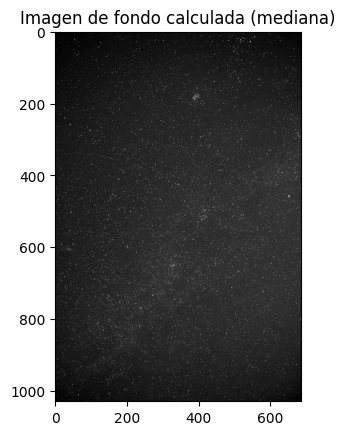

Ejecutando sustracción acelerada...
Umbralización completada.
RESULTADO: Existe Asteroide


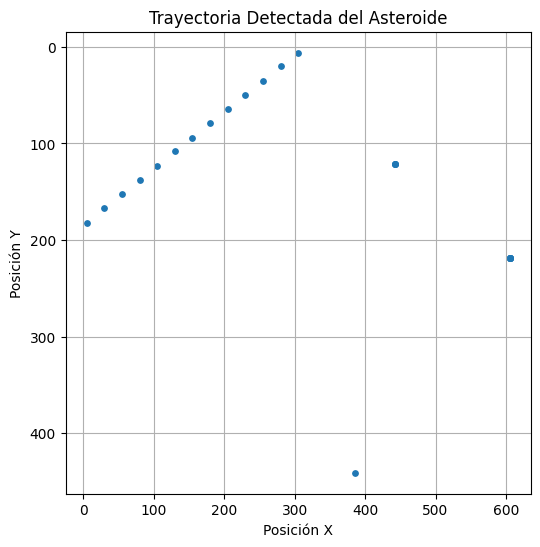

In [1]:
# 1. Instalación de librerías
!pip install cupy-cuda12x --quiet
!pip install opencv-python --quiet
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os
from google.colab import files


# 2. Cargar video desde Colab
print("Sube tu archivo .mp4 del asteroide:")
uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print("Video cargado:", video_path)


# 3. Convertir video a frames
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("No se pudo abrir el video.")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
    cap.release()

    return np.array(frames)

print("Cargando frames...")
frames_cpu = load_video_frames(video_path)
print("Frames cargados:", frames_cpu.shape)


# 4. Calcular imagen de fondo (mediana)
print("Calculando fondo por mediana (GPU)...")

frames_gpu = cp.asarray(frames_cpu)
background_gpu = cp.median(frames_gpu, axis=0)
background = background_gpu.get()

plt.title("Imagen de fondo calculada (mediana)")
plt.imshow(background, cmap="gray")
plt.show()


# 5. Resta acelerada en GPU
def detect_changes_gpu(frames_cpu, background):
    frames_gpu = cp.asarray(frames_cpu)
    bg_gpu = cp.asarray(background)

    # Resta pixel a pixel paralela en GPU
    diff_gpu = cp.abs(frames_gpu - bg_gpu)

    return diff_gpu.get()

print("Ejecutando sustracción acelerada...")
diff_frames = detect_changes_gpu(frames_cpu, background)


# 6. Umbralización (detección del asteroide)
THRESHOLD = 35   # Ajustable según el video

binary_frames = diff_frames > THRESHOLD

print("Umbralización completada.")


# 7. Extraer posiciones (x,y) del asteroide
positions = []

for t, frame in enumerate(binary_frames):
    ys, xs = np.where(frame == True)
    if len(xs) > 0:
        cx = int(np.mean(xs))
        cy = int(np.mean(ys))
        positions.append((t, cx, cy))

positions = np.array(positions)


# 8. Veredicto final
if len(positions) > 0:
    print("RESULTADO: Existe Asteroide")
else:
    print("RESULTADO: No Existe Asteroide")


# 9. Gráfica de trayectoria
if len(positions) > 0:
    ts = positions[:,0]
    xs = positions[:,1]
    ys = positions[:,2]

    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys, s=15)
    plt.gca().invert_yaxis()
    plt.title("Trayectoria Detectada del Asteroide")
    plt.xlabel("Posición X")
    plt.ylabel("Posición Y")
    plt.grid(True)
    plt.show()
else:
    print("No hay puntos para graficar.")
